# Implement Style-transfering



    + implementation of the algorithm described in "A Neural Algorithm of Artistic Style" 
    
    + An image is generated which combines the content of a photograph with the "style" of a painting. 
    
    + This is accomplished by jointly minimizing the squared difference between feature activation maps of the photo and generated image, and the squared difference of feature correlation between painting and generated image. A total variation penalty is also applied to reduce high frequency noise.
    
    +  Uses a GoogLeNet network (pre-trained and pre-loaded), in TensorFlow and given some features to make it easier to experiment with.



In [1]:
import tensorflow as tf

import numpy as np
import scipy
import scipy.misc  # for imresize


import matplotlib.pyplot as plt
%matplotlib inline

import time

#from urllib.request import urlopen  # Python 3+ version (instead of urllib2)
from urllib2 import urlopen

import os # for directory listings
import pickle

AS_PATH='./images/art-style'


/home/root1/.virtualenv/demos/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
# Get hold of Google's model zoo

import os, sys

tf_zoo_models_dir = './models/tensorflow_zoo'

if not os.path.exists(tf_zoo_models_dir):
    print("Creating model/tensorflow_zoo directory")
    os.makedirs(tf_zoo_models_dir)
    
if not os.path.isfile( os.path.join(tf_zoo_models_dir, 'models', 'README.md') ):
    print("Cloning tensorflow model zoo under %s" % (tf_zoo_models_dir, ))
    !cd {tf_zoo_models_dir}; git clone https://github.com/tensorflow/models.git

sys.path.append(tf_zoo_models_dir + "/models/research/slim")

print("Model Zoo model code installed")



Model Zoo model code installed


### Inception is trained on image-net


![Image net](https://image.slidesharecdn.com/dlcvd2l4imagenet-160802094728/95/deep-learning-for-computer-vision-imagenet-challenge-upc-2016-4-638.jpg "Image net")

Inception : Google's model to attack this problem

Called "Inception" becuase it has network within network


![Inception](https://4.bp.blogspot.com/-TMOLlkJBxms/Vt3HQXpE2cI/AAAAAAAAA8E/7X7XRFOY6Xo/s1600/image03.pngg "Inception model")

It has ~100 layers with 23 million paramters !

In [5]:
import keras

m = keras.applications.inception_v3.InceptionV3(include_top=True, weights='imagenet', input_tensor=None)

Using TensorFlow backend.


In [6]:
m.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 149, 149, 32)  864                                          
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 149, 149, 32)  96                                           
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 149, 149, 32)  0                                            
___________________________________________________________________________________________

#  Download the Inception V1 checkpoint

Functions for building the GoogLeNet model with TensorFlow / slim and preprocessing the images are defined in model.inception_v1_tf - which was downloaded from the TensorFlow / slim Model Zoo.


In [8]:
# get hold of v1 checkpoint of inception model

from datasets import dataset_utils

targz = "inception_v1_2016_08_28.tar.gz"
url = "http://download.tensorflow.org/models/"+targz
checkpoints_dir = './data/tensorflow_zoo/checkpoints'

if not os.path.exists(checkpoints_dir):
    os.makedirs(checkpoints_dir)

if not os.path.isfile( os.path.join(checkpoints_dir, 'inception_v1.ckpt') ):
    tarfilepath = os.path.join(checkpoints_dir, targz)
    if os.path.isfile(tarfilepath):
        import tarfile
        tarfile.open(tarfilepath, 'r:gz').extractall(checkpoints_dir)
    else:
        dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)
        
    # Get rid of tarfile source (the checkpoint itself will remain)
    os.unlink(tarfilepath)
        
print("Checkpoint available locally")




Checkpoint available locally


### Build the model and select layers we need - the features are taken from the final network layer, before the softmax nonlinearity.

In [9]:
slim = tf.contrib.slim

from nets import inception
from preprocessing import inception_preprocessing

image_size = inception.inception_v1.default_image_size
image_size

IMAGE_W=224


In [10]:
def prep_image(im):
    if len(im.shape) == 2:
        im = im[:, :, np.newaxis]
        im = np.repeat(im, 3, axis=2)
        
    # Resize so smallest dim = 224, preserving aspect ratio
    h, w, _ = im.shape
    if h < w:
        im = scipy.misc.imresize(im, (224, int(w*224/h)))
    else:
        im = scipy.misc.imresize(im, (int(h*224/w), 224))

    # Central crop to 224x224
    h, w, _ = im.shape
    im = im[h//2-112:h//2+112, w//2-112:w//2+112]
    
    rawim = np.copy(im).astype('uint8')
    
    # Now rescale it to [-1,+1].float32 from [0..255].unit8
    im = ( im.astype('float32')/255.0 - 0.5 ) * 2.0
    return rawim, im


# Choose the Photo to be Enhanced

In [12]:
photos = [ '%s/photos/%s' % (AS_PATH, f) for f in os.listdir('%s/photos/' % AS_PATH) if not f.startswith('.')]
photo_i=-1 # will be incremented in next cell (i.e. to start at [0])

/home/root1/.virtualenv/demos/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


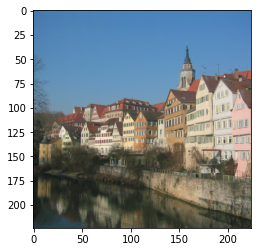

In [13]:
photo_i += 1
photo = plt.imread(photos[photo_i % len(photos)])
photo_rawim, photo = prep_image(photo)
plt.imshow(photo_rawim)

# Choose the photo with the required 'Style'

In [14]:
styles = [ '%s/styles/%s' % (AS_PATH, f) for f in os.listdir('%s/styles/' % AS_PATH) if not f.startswith('.')]
style_i=-1 # will be incremented in next cell (i.e. to start at [0])

/home/root1/.virtualenv/demos/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


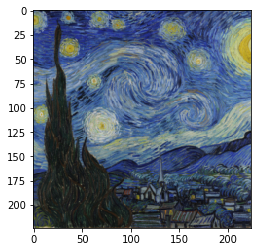

In [15]:

style_i += 1
style = plt.imread(styles[style_i % len(styles)])
style_rawim, style = prep_image(style)
plt.imshow(style_rawim)

In [16]:
def plot_layout(artwork):
    def no_axes():
        plt.gca().xaxis.set_visible(False)    
        plt.gca().yaxis.set_visible(False)    
        
    plt.figure(figsize=(9,6))

    plt.subplot2grid( (2,3), (0,0) )
    no_axes()
    plt.imshow(photo_rawim)

    plt.subplot2grid( (2,3), (1,0) )
    no_axes()
    plt.imshow(style_rawim)

    plt.subplot2grid( (2,3), (0,1), colspan=2, rowspan=2 )
    no_axes()
    plt.imshow(artwork, interpolation='nearest')

    plt.tight_layout()

# Precompute layer activations for photo and artwork

In [17]:
tf.reset_default_graph()

# This creates an image 'placeholder' - image inputs should be (224,224,3).float32 each [-1.0,1.0]
input_image_float = tf.placeholder(tf.float32, shape=[None, None, 3], name='input_image_float')
#input_image_var = tf.Variable(tf.zeros([image_size,image_size,3], dtype=tf.uint8), name='input_image_var' )

# Define the pre-processing chain within the graph - based on the input 'image' above
#processed_image = inception_preprocessing.preprocess_image(input_image, image_size, image_size, is_training=False)

processed_image = input_image_float
processed_images = tf.expand_dims(processed_image, 0)

print("Model builder starting")

# Here is the actual model zoo model being instantiated :
with slim.arg_scope(inception.inception_v1_arg_scope()):
    _, end_points = inception.inception_v1(processed_images, num_classes=1001, is_training=False)

# Create an operation that loads the pre-trained model from the checkpoint
init_fn = slim.assign_from_checkpoint_fn(
    os.path.join(checkpoints_dir, 'inception_v1.ckpt'),
    slim.get_model_variables('InceptionV1')
)

print("Model defined")

Model builder starting
Model defined


In [18]:
#dir(slim.get_model_variables('InceptionV1')[10])
#[ v.name for v in slim.get_model_variables('InceptionV1') ]
sorted(end_points.keys())
#dir(end_points['Mixed_4b'])
#end_points['Mixed_4b'].name

['AvgPool_0a_7x7',
 'Conv2d_1a_7x7',
 'Conv2d_2b_1x1',
 'Conv2d_2c_3x3',
 'Logits',
 'MaxPool_2a_3x3',
 'MaxPool_3a_3x3',
 'MaxPool_4a_3x3',
 'MaxPool_5a_2x2',
 'Mixed_3b',
 'Mixed_3c',
 'Mixed_4b',
 'Mixed_4c',
 'Mixed_4d',
 'Mixed_4e',
 'Mixed_4f',
 'Mixed_5b',
 'Mixed_5c',
 'Predictions']

In [19]:
photo_layers = [
    # used for 'content' in photo - a mid-tier convolutional layer 
    'Mixed_4b',      #Theano : 'inception_4b/output', 
#    'pool4/3x3_s2', 
]

style_layers = [
    # used for 'style' - conv layers throughout model (not same as content one)
    'Conv2d_1a_7x7', #Theano : 'conv1/7x7_s2',        
    'Conv2d_2c_3x3', #Theano : 'conv2/3x3', 
    'Mixed_3b',      #Theano : 'inception_3b/output',  
    'Mixed_4d',      #Theano : 'inception_4d/output',

#    'conv1/7x7_s2', 'conv2/3x3', 'pool3/3x3_s2', 'inception_5b/output',
]
all_layers = photo_layers+style_layers

In [20]:
# Actually, we'll capture more data than necessary, so we can compare the how they look (below)
photo_layers_capture = all_layers  # more minimally = photo_layers
style_layers_capture = all_layers  # more minimally = style_layers

In [21]:
# Now let's run the pre-trained model on the photo and the style
style_features={}
photo_features={}

with tf.Session() as sess:
    # This is the loader 'op' we defined above
    init_fn(sess)  
    
    # This run grabs all the layer constants for the original photo image input
    photo_layers_np = sess.run([ end_points[k] for k in photo_layers_capture ], feed_dict={input_image_float: photo})
    
    for i,l in enumerate(photo_layers_np):
        photo_features[ photo_layers_capture[i] ] = l

    # This run grabs all the layer constants for the style image input
    style_layers_np = sess.run([ end_points[k] for k in style_layers_capture ], feed_dict={input_image_float: style})
    
    for i,l in enumerate(style_layers_np):
        style_features[ style_layers_capture[i] ] = l

    # Helpful display of 
    for i,name in enumerate(all_layers):
        desc = []
        if name in style_layers:
            desc.append('style')
            l=style_features[name]
        if name in photo_layers:
            desc.append('photo')
            l=photo_features[name]
        print("  Layer[%d].shape=%18s, %s.name = '%s'" % (i, str(l.shape), '+'.join(desc), name,))

INFO:tensorflow:Restoring parameters from ./data/tensorflow_zoo/checkpoints/inception_v1.ckpt
  Layer[0].shape=  (1, 14, 14, 512), photo.name = 'Mixed_4b'
  Layer[1].shape= (1, 112, 112, 64), style.name = 'Conv2d_1a_7x7'
  Layer[2].shape=  (1, 56, 56, 192), style.name = 'Conv2d_2c_3x3'
  Layer[3].shape=  (1, 28, 28, 256), style.name = 'Mixed_3b'
  Layer[4].shape=  (1, 14, 14, 512), style.name = 'Mixed_4d'


Layer Name : 'Mixed_4b'


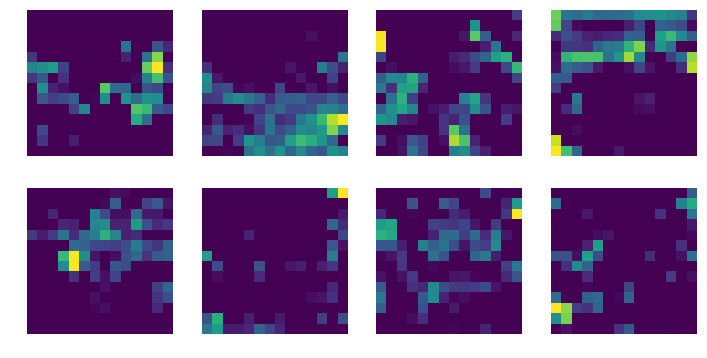

Layer Name : 'Conv2d_1a_7x7'


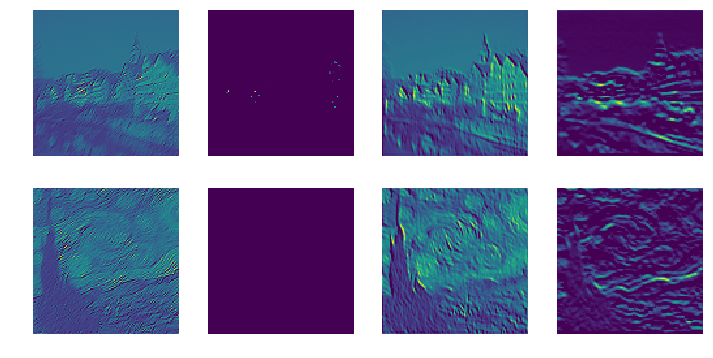

Layer Name : 'Conv2d_2c_3x3'


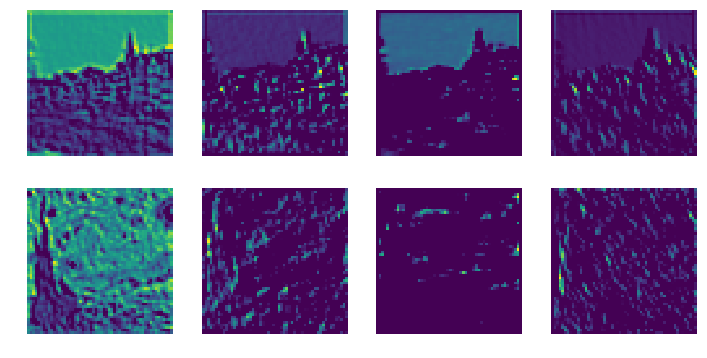

Layer Name : 'Mixed_3b'


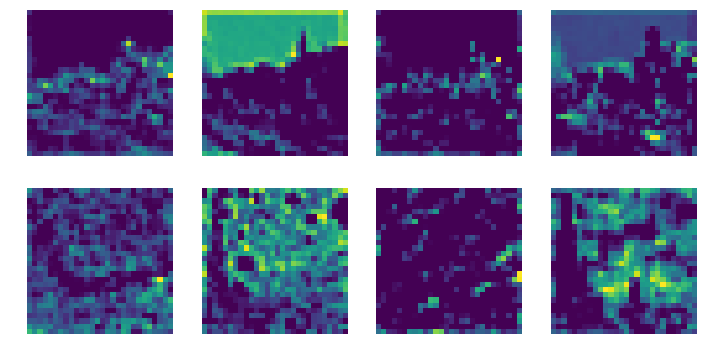

Layer Name : 'Mixed_4d'


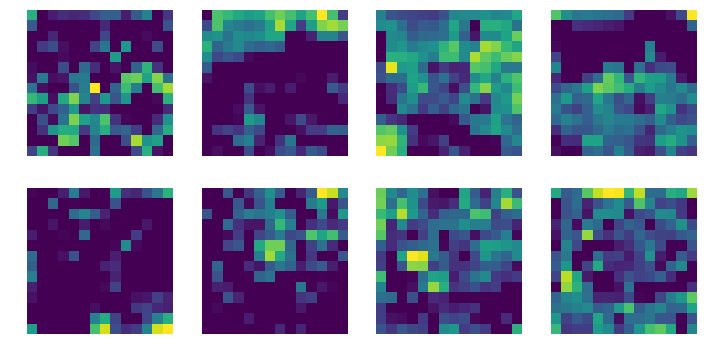

In [22]:
for name in all_layers:
    print("Layer Name : '%s'" % (name,))
    plt.figure(figsize=(12,6))
    for i in range(4):
        if name in photo_features:
            plt.subplot(2, 4, i+1)
            plt.imshow(photo_features[ name ][0, :, :, i], interpolation='nearest') # , cmap='gray'
            plt.axis('off')
        
        if name in style_features:
            plt.subplot(2, 4, 4+i+1)
            plt.imshow(style_features[ name ][0, :, :, i], interpolation='nearest') #, cmap='gray'
            plt.axis('off')
    plt.show()

# Define the overall loss / badness function

In [23]:
art_features = {}
for name in all_layers:  
    art_features[name] = end_points[name]

In [24]:
def gram_matrix(tensor):
    shape = tensor.get_shape()
    
    # Get the number of feature channels for the input tensor,
    # which is assumed to be from a convolutional layer with 4-dim.
    num_channels = int(shape[3])

    # Reshape the tensor so it is a 2-dim matrix. This essentially
    # flattens the contents of each feature-channel.
    matrix = tf.reshape(tensor, shape=[-1, num_channels])
    
    # Calculate the Gram-matrix as the matrix-product of
    # the 2-dim matrix with itself. This calculates the
    # dot-products of all combinations of the feature-channels.
    gram = tf.matmul(tf.transpose(matrix), matrix)
    return gram

def content_loss(P, X, layer):
    p = tf.constant( P[layer] )
    x = X[layer]
    
    loss = 1./2. * tf.reduce_mean(tf.square(x - p))
    return loss

def style_loss(S, X, layer):
    s = tf.constant( S[layer] )
    x = X[layer]
    
    S_gram = gram_matrix(s)
    X_gram = gram_matrix(x)
    
    layer_shape = s.get_shape()
    N = layer_shape[1]
    M = layer_shape[2] * layer_shape[3]
    
    loss = tf.reduce_mean(tf.square(X_gram - S_gram)) / (4. * tf.cast( tf.square(N) * tf.square(M), tf.float32))
    return loss

def total_variation_loss_l1(x):
    loss = tf.add( 
            tf.reduce_sum(tf.abs(x[1:,:,:] - x[:-1,:,:])), 
            tf.reduce_sum(tf.abs(x[:,1:,:] - x[:,:-1,:]))
           )
    return loss

def total_variation_loss_lX(x):
    loss = tf.reduce_sum(
            tf.pow( 
                tf.square( x[1:,:-1,:] - x[:-1,:-1,:]) + tf.square( x[:-1,1:,:] - x[:-1,:-1,:]),
                1.25)
           )
    return loss

In [25]:
# And here are some more TF nodes, to compute the losses using the layer values 'saved off' earlier
losses = []

# content loss
cl = 10.
losses.append(cl *1.     * content_loss(photo_features, art_features, 'Mixed_4b'))

# style loss
sl = 2. *1000. *1000.
losses.append(sl *1.     * style_loss(style_features, art_features, 'Conv2d_1a_7x7'))
losses.append(sl *1.     * style_loss(style_features, art_features, 'Conv2d_2c_3x3'))
losses.append(sl *10.    * style_loss(style_features, art_features, 'Mixed_3b'))
losses.append(sl *10.    * style_loss(style_features, art_features, 'Mixed_4d'))

# total variation penalty
vp = 10. /1000. /1000.
losses.append(vp *1.     * total_variation_loss_lX(input_image_float))
#losses.append(vp *1.     * total_variation_loss_l1(input_image_float))


# ['193.694946', '5.038591', '1.713539', '8.238111', '0.034608', '9.986152']
# ['0.473700', '0.034096', '0.010799', '0.021023', '0.164272', '0.539243']
# ['2.659750', '0.238304', '0.073061', '0.190739', '0.806217', '3.915816']
# ['1.098473', '0.169444', '0.245660', '0.109285', '0.938582', '0.028973']
# ['0.603620', '1.707279', '0.498789', '0.181227', '0.060200', '0.002774']
# ['0.788231', '0.920096', '0.358549', '0.806517', '0.256121', '0.002777']

total_loss = tf.reduce_sum(losses)

# And define the overall symbolic gradient operation
total_grad = tf.gradients(total_loss, [input_image_float])[0]

# Get Ready for Optimisation by SciPy
This uses the BFGS routine :

R. H. Byrd, P. Lu and J. Nocedal. A Limited Memory Algorithm for Bound Constrained Optimization, (1995), SIAM Journal on Scientific and Statistical Computing, 16, 5, pp. 1190-1208.
Initialize with the original photo, since going from noise (the code that's commented out) takes many more iterations :

In [26]:
art_image = photo
#art_image = np.random.uniform(-1.0, +1.0, (image_size, image_size, 3))

x0 = art_image.flatten().astype('float64')
iteration=0

# Optimize all those losses, and show the image
To refine the result, just keep hitting 'run' on this cell (each iteration is about 60 seconds) :

INFO:tensorflow:Restoring parameters from ./data/tensorflow_zoo/checkpoints/inception_v1.ckpt
('\nEval Loss @ ', ['0.003922', '0.396078', '-0.443137', '0.003922', '0.411765', '-0.443137'], ' = ', 72679.14)
('Eval loss components = ', ['0.000000', '72368.351562', '242.517517', '64.664154', '3.592585', '0.017817'])
('\nEval Loss @ ', ['0.002364', '0.395022', '-0.441621', '0.002511', '0.412203', '-0.441876'], ' = ', 70784.984)
('Eval loss components = ', ['0.000182', '70479.273438', '238.384293', '63.741280', '3.570509', '0.017886'])
('\nEval Loss @ ', ['-0.003868', '0.390798', '-0.435557', '-0.003131', '0.413958', '-0.436832'], ' = ', 63559.883)
('Eval loss components = ', ['0.004380', '63274.292969', '221.949692', '60.121620', '3.497241', '0.018184'])
('\nEval Loss @ ', ['-0.028796', '0.373901', '-0.411299', '-0.025699', '0.420976', '-0.416657'], ' = ', 40618.95)
('Eval loss components = ', ['0.062904', '40403.277344', '164.253632', '48.147835', '3.187041', '0.019695'])
('\nEval Loss @ 

('\nEval Loss @ ', ['-0.221595', '0.126131', '-0.556095', '-0.189089', '0.154694', '-0.589538'], ' = ', 51.920357)
('Eval loss components = ', ['1.034843', '41.286861', '4.297492', '4.446033', '0.831683', '0.023443'])
('\nEval Loss @ ', ['-0.224086', '0.124942', '-0.564067', '-0.195493', '0.149899', '-0.597323'], ' = ', 49.22214)
('Eval loss components = ', ['1.051354', '39.010269', '4.117015', '4.210109', '0.809821', '0.023574'])
('\nEval Loss @ ', ['-0.222992', '0.126206', '-0.574655', '-0.201590', '0.146226', '-0.608516'], ' = ', 58.99126)
('Eval loss components = ', ['1.073858', '49.703705', '3.720750', '3.711177', '0.758134', '0.023635'])
('\nEval Loss @ ', ['-0.223822', '0.125247', '-0.566622', '-0.196965', '0.149013', '-0.600025'], ' = ', 48.104046)
('Eval loss components = ', ['1.056811', '38.174400', '3.995462', '4.058293', '0.795505', '0.023576'])
('\nEval Loss @ ', ['-0.224896', '0.125051', '-0.573678', '-0.202254', '0.145519', '-0.607344'], ' = ', 45.004578)
('Eval loss com

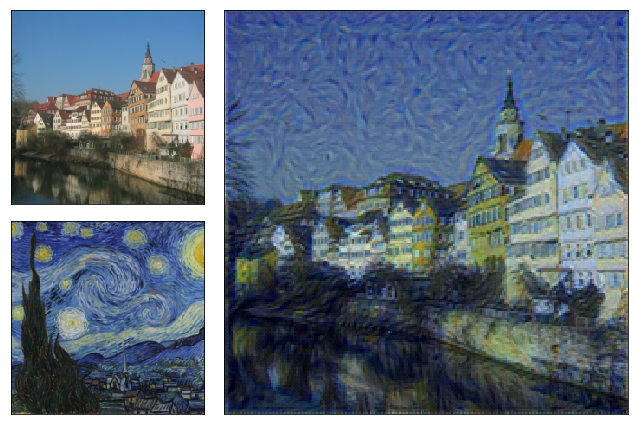

In [27]:
t0 = time.time()

with tf.Session() as sess:
    init_fn(sess)
    
    # This helper function (to interface with scipy.optimize) must close over sess
    def eval_loss_and_grad(x):  # x0 is a 3*image_size*image_size float64 vector
        x_image = x.reshape(image_size,image_size,3).astype('float32')
        x_loss, x_grad = sess.run( [total_loss, total_grad], feed_dict={input_image_float: x_image} )
        print("\nEval Loss @ ", [ "%.6f" % l for l in x[100:106]], " = ", x_loss)
        #print("Eval Grad = ", [ "%.6f" % l for l in x_grad.flatten()[100:106]] )
        
        losses_ = sess.run( losses, feed_dict={input_image_float: x_image} )
        print("Eval loss components = ", [ "%.6f" % l for l in losses_])
        
        return x_loss.astype('float64'), x_grad.flatten().astype('float64')

    x0, x0_loss, state = scipy.optimize.fmin_l_bfgs_b( eval_loss_and_grad, x0, maxfun=50) 
    iteration += 1

print("Iteration %d, in %.1fsec, Current loss : %.4f" % (iteration, float(time.time() - t0), x0_loss))

art_raw = np.clip( ((x0*0.5 + 0.5) * 255.0), a_min=0.0, a_max=255.0 )
plot_layout( art_raw.reshape(image_size,image_size,3).astype('uint8') )